In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import time
import torch
import skimage
import numpy as np
import ase.io as aio
from ase import Atoms
from toolz.curried import pipe, curry

In [3]:
import plot
import atommks.helpers as utils

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [12.0, 9.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

In [5]:
def grid_maker(fname, len_pixel=1, r_atom=5.0, verbose=True):
    import atommks.grid_generator as gen
    
    atoms = pipe(fname, 
                 lambda f: utils.load_file(f), 
                 lambda a: get_atoms(a))
    
    idx = np.where(atoms.get_tags() != 1)[0]    
    if len(idx) == 0:
        np.random.seed(81396)
        idx = np.random.randint(low=0, high=len(atoms), size=2000)
    
    coords_all = atoms.get_positions()
    coords_sub = coords_all[idx]
    
    if verbose:
        print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))
    
    atoms_1 = Atoms(positions=coords_sub,  cell=atoms.get_cell(), pbc=atoms.get_pbc())
    radii = {}
    for idx in sorted(np.unique(atoms_1.get_chemical_symbols())):
        radii[idx] = r_atom    
    return gen.grid_maker(atoms_1, len_pixel=len_pixel, atomic_radii=radii, full=True, fft=True)[1][0]

data/structs/dump.arc.500_atom.pkl
total atoms: 4000000, disturbed atoms: 87589


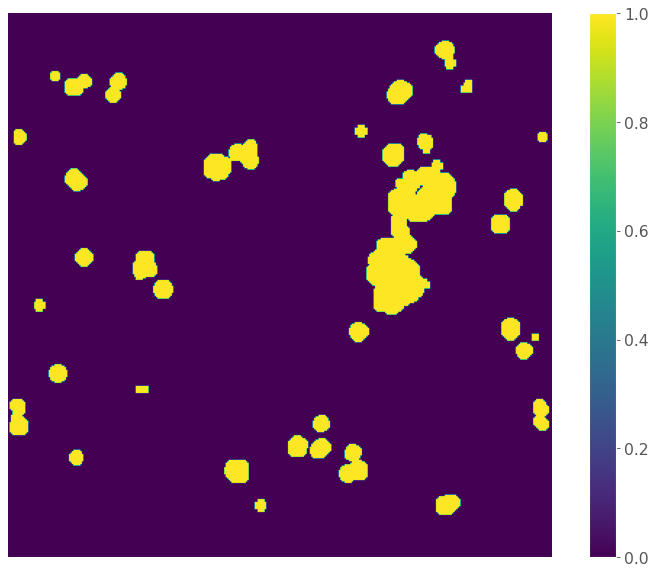

CPU times: user 24 s, sys: 4.06 s, total: 28.1 s
Wall time: 4.01 s


In [6]:
%%time
len_pixel = 1
r_atom = 5.0

run = runs[1]
fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
print(fname)
S_cas = grid_maker(fname, len_pixel=len_pixel, r_atom=r_atom)
idx = S_cas.shape[-1]//2
plot.draw_2d(S_cas[:,:,idx])

In [ ]:
# # label using volume
# d = utils.load_file("data/grids/dump.arc.{}_grid.pkl".format(runs[1]))
# props = skimage.measure.regionprops(d["lbl"])

# d_lbl = d["lbl"]

# lbls = np.unique(d_lbl)
# vols = [p.area for p in props]

# d_vol = d_lbl.copy()
# for i0, lbl in enumerate(lbls[1:]):
#     d_vol[np.where(d_lbl==lbl)] = vols[i0]
    
# utils.write2vtk(matrix=d_vol, fname="zeo_vol.vtk")

In [7]:
from skimage.measure import label, regionprops, regionprops_table
S_lbl, l_count = label(S_cas, return_num=True)
print("No. of discreete regions: {}".format(l_count))
prop = regionprops_table(S_lbl, properties=["area", "centroid"])

No. of discreete regions: 523


In [9]:
@curry
def prop_maker(run, r_list=np.arange(1, 7.01, 1.0), len_pixel=1, f_tag="data/props_big/"):
    from skimage.measure import label, regionprops_table
    
    fname = "data/structs/dump.arc.{}_atom.pkl".format(run)
    
    dct = {}
    counts = []
    for r_atom in r_list:
        S_cas = grid_maker(fname, len_pixel=len_pixel, r_atom=r_atom, verbose=False)
        S_lbl, count = label(S_cas, return_num=True)
        dct[r_atom] = regionprops_table(S_lbl, properties=["area", "centroid"])
        counts.append(count)
    fout = f_tag + "dump.arc.{}_props.pkl".format(run)
    print("{}, No. of discreete regions: {}\n".format(run, counts))
    utils.save_file(fname=fout, obj=dct)

In [10]:
import multiprocessing as mp
n_proc = 10
with mp.Pool(n_proc) as p:
    p.map(prop_maker(r_list=np.arange(1.0, 7.01, 1.), len_pixel=1, f_tag="data/props_big/"), runs[1:])

500, No. of discreete regions: [79695, 965, 759, 612, 523, 439, 367]

1500, No. of discreete regions: [155403, 1984, 1462, 1109, 836, 556, 376]

2500, No. of discreete regions: [172706, 2405, 1771, 1260, 906, 564, 330]

3500, No. of discreete regions: [187894, 2794, 1998, 1356, 889, 511, 278]

4500, No. of discreete regions: [220332, 2650, 1860, 1242, 778, 429, 218]

9500, No. of discreete regions: [238750, 3062, 2088, 1318, 746, 353, 146]

6500, No. of discreete regions: [236155, 2850, 1972, 1258, 774, 394, 197]

7500, No. of discreete regions: [232538, 2921, 2006, 1290, 742, 352, 163]

5500, No. of discreete regions: [249773, 2676, 1860, 1237, 767, 372, 197]

8500, No. of discreete regions: [252286, 2879, 1949, 1204, 689, 308, 137]

1000, No. of discreete regions: [120484, 1549, 1200, 940, 741, 566, 417]

2000, No. of discreete regions: [165930, 2187, 1622, 1201, 878, 550, 345]

3000, No. of discreete regions: [188373, 2598, 1877, 1264, 855, 501, 273]

4000, No. of discreete regions:

time elapsed in rdf computation (defects only): 10.180s


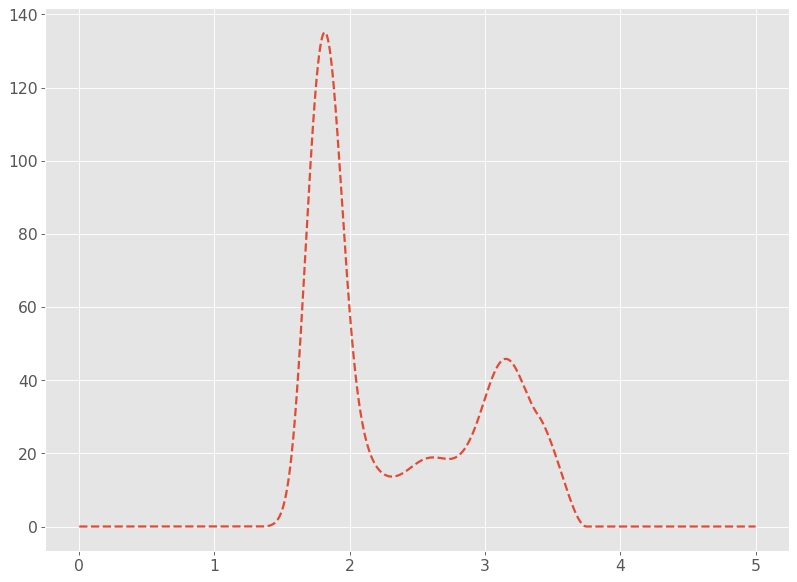

In [155]:
@curry
def get_smooth_rdf(a, r_stat, width, len_pixel=1000, defects_only=True, verbose=True):
    
    import atommks_v1.atomstat as astat
    idx = np.where(a.get_tags() != 1)[0]
    
    if verbose:
        print("total atoms: {}, disturbed atoms: {}".format(len(a), len(idx)))
        
    if defects_only:
        coords_all = a.get_positions()[idx]
    else:
        coords_all = a.get_positions()
        
    coords_sub = a.get_positions()[idx]
    coords_stat = astat.get_realStats(coords_all, 
                                  coords_sub, 
                                  cell_dim=a.get_cell_lengths_and_angles(),
                                  cell=a.get_cell(), 
                                  pbc=a.get_pbc(),
                                  r_stat=r_stat,
                                  cutoff=r_stat+1.0,)
    rdf, pdf, bin_centers = astat.get_rdf(coords_stat, r_stat, len_pixel=len_pixel)
    kernel = utils.epanechnikov_kernel(width=width, x=bin_centers)
    return utils.convolve_kernel(kernel, pdf)

to_arr = lambda L: np.concatenate([l[None] for l in L], axis=0)

r_stat = 5.0
width_rdf = 0.25
len_pixel=1000 

gen_rdfs_def = get_smooth_rdf(r_stat=r_stat, width=width_rdf, len_pixel=len_pixel, defects_only=True, verbose=False)
# gen_rdfs_all = get_smooth_rdf(r_stat=r_stat, width=width_rdf, len_pixel=len_pixel, defects_only=False, verbose=False)

ix = 1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
     lambda f: utils.load_file(f), 
     lambda a: get_atoms(a))

strt = time.time()
rdf_def = gen_rdfs_def(atoms)
print("time elapsed in rdf computation (defects only): {:1.3f}s".format(time.time()-strt))

plt.plot(np.linspace(0.0, r_stat, len(rdf_def)), rdf_def, "--")
plt.show()

In [ ]:
%%time
@curry
def generate_stats(run, folder_rdf="data/rdfs_def"):
    
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
         lambda f: utils.load_file(f), 
         lambda a: get_atoms(a))
    
    rdf_def = gen_rdfs_def(atoms)
    f_out = "{}/dump.arc.{}_stat.pkl".format(folder_rdf, run)
    utils.save_file(fname=f_out, obj=rdf_def)
    print(f_out)
    
import multiprocessing as mp
n_proc = 12
with mp.Pool(n_proc) as p:
    p.map(generate_stats(folder_rdf="data/rdfs_def"), runs[1:])

In [ ]:
import porespy as ps

im = ps.generators.blobs(shape=[100, 100, 100], porosity=0.08, blobiness=2)

plot.draw_2d(im[:,:,50])


data = ps.metrics.two_point_correlation_fft(im)
fig = plt.plot(*data, 'bo-')
plt.ylabel('probability')
plt.xlabel('correlation length [voxels]')

data = ps.metrics.two_point_correlation_fft(S_cas)
fig = plt.plot(*data, 'bo-')
plt.ylabel('probability')
plt.xlabel('correlation length [voxels]')